In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator , TransformerMixin,clone
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score , cross_val_predict , cross_validate,train_test_split,StratifiedKFold,ShuffleSplit
from sklearn.metrics import classification_report , classification,accuracy_score ,roc_auc_score
import os 
import matplotlib

In [2]:
# Loading different algorithms to ensemble 

from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier , VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 

In [3]:
%matplotlib inline

In [4]:
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA

In [5]:
from sklearn.datasets import fetch_mldata

In [6]:
MNIST = fetch_mldata('MNIST Original')
MNIST['COL_NAMES']
x = MNIST['data']
y = MNIST['target']

In [7]:
pca_decomp = PCA(random_state = 42)
pca_decomp.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

Lets see how much first PC is explaining variance. 

First PCA always explains highest variance. Highest variance (Sum of Square) is 334294 that contibutes 9.7% of the total variance

In [8]:
pca_decomp.explained_variance_ratio_[0] * 100 

9.746115922494743

The important question is what is the composition first. Which columns contibuted higher than rest of the column in calculation

In [9]:
pd.DataFrame(pca_decomp.components_[:, 0].T).sort_values(by = 0).head(10)

,0
707,-1.816737e-16
711,-9.795575e-17
705,-9.367211e-17
695,-7.628570e-17
697,-7.562314e-17
677,-5.839751e-17
674,-5.310914e-17
700,-4.286613e-17
689,-3.083784e-17
681,-2.878252e-17


These are the 10 highest contributing features in construction of first PCA. Do not forget, Magnitude is in opposite direrction. That means pca 1 plane is projected in opposite direction of plane

Repeating same task for PCA 2

In [10]:
print(pca_decomp.explained_variance_[1])
print(pca_decomp.explained_variance_ratio_[1])

245433.42714427295
0.07155444586878684


In [11]:
pd.DataFrame(pca_decomp.components_[:, 1].T).sort_values(by = 0).head(10)

,0
782,-0.297781
738,-0.237779
736,-0.233254
780,-0.214762
730,-0.212192
751,-0.196021
742,-0.195535
735,-0.184247
750,-0.155429
743,-0.151871


One of the reasons to decompose variables to reduce dimension. PCA does this job for us using Singular Value Decoposition (SVD).
However the question is how many PCs? Let's figure it out

In [12]:
cumsum = np.cumsum(pca_decomp.explained_variance_ratio_)

In [13]:
d = np.argmax(cumsum > 0.95) + 1 

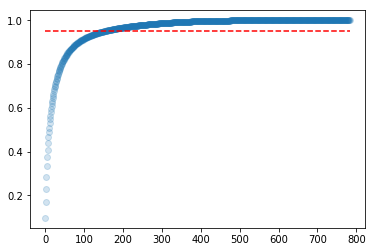

In [14]:
plt.plot(cumsum, 'o', alpha = 0.2)
plt.plot(np.array([0.95] * len(cumsum)), 'r--', label = 'Threshold')

In [15]:
PC1 = pca_decomp.components_[:]

154 components are explaning 95 % of total variance. So, instead of taking 784 variables, we can take 154 components that shares 95 % of information in the features

Lets train random forest, on PCA vs w/o PCA

In [16]:
rf_clf = RandomForestClassifier(max_depth= 2, random_state= 42)

In [17]:
x_train , x_test , y_train , y_test = train_test_split(x, y , test_size = 0.3)

In [18]:
rf_clf.fit(x_train, y_train)
y_rf_pred = rf_clf.predict(x_test)
print(accuracy_score(y_test, y_rf_pred))
print(classification_report(y_test , y_rf_pred))

0.5945714285714285
             precision    recall  f1-score   support

        0.0       0.63      0.93      0.75      2040
        1.0       0.54      0.97      0.70      2353
        2.0       0.70      0.57      0.63      2119
        3.0       0.57      0.62      0.60      2137
        4.0       0.47      0.47      0.47      2068
        5.0       0.88      0.02      0.05      1875
        6.0       0.72      0.73      0.73      2046
        7.0       0.66      0.76      0.71      2239
        8.0       0.74      0.35      0.47      2078
        9.0       0.43      0.39      0.41      2045

avg / total       0.63      0.59      0.56     21000



In [19]:
pca_rf_clf = clone(rf_clf)
pca_decomp = PCA(n_components= 154)
pca_rf_pipeline = Pipeline([('pca', pca_decomp),
                           ('forest', pca_rf_clf)])

In [20]:
pca_rf_pipeline.fit(x_train, y_train)
y_pca_rf_pred = pca_rf_pipeline.predict(x_test)
print(accuracy_score(y_test, y_pca_rf_pred))
print(classification_report(y_test , y_pca_rf_pred))

0.5395238095238095
             precision    recall  f1-score   support

        0.0       0.84      0.46      0.59      2040
        1.0       0.65      0.93      0.76      2353
        2.0       0.40      0.57      0.47      2119
        3.0       0.43      0.68      0.53      2137
        4.0       0.58      0.72      0.64      2068
        5.0       0.48      0.17      0.26      1875
        6.0       0.56      0.58      0.57      2046
        7.0       0.52      0.75      0.62      2239
        8.0       0.59      0.13      0.21      2078
        9.0       0.56      0.30      0.39      2045

avg / total       0.56      0.54      0.51     21000



As suspected accuracy is reduduced, however time to train model decreased

Lets see how does it do in visulization. Since one of the primary use of PCA to visulize multiple data into 2 dimensions of data into two dimension data

In [21]:
x_reduced = pca_decomp.fit_transform(x)

Text(0,0.5,'PCA2')

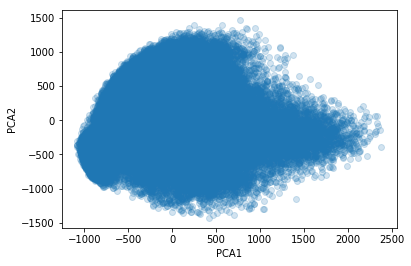

In [22]:
plt.scatter(x_reduced[:, 0], x_reduced[:,1], alpha = 0.2)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

There is an alternative of sklearn's PCA which is sklearn's IncrementalPCA. This method can be useful when we dont want to set whole data set into memory. Instead IncrementalPCA divides data into batches and feed algorithm "PARTIALLY"

In [23]:
ipca = IncrementalPCA(n_components= 154)

In [24]:
n_batches = 100 
for x_batch in np.array_split(x, n_batches): 
    ipca.partial_fit(x_batch)


In [25]:
ipca.transform(x)

array([[1010.4938683 ,  289.98656863, -576.13114671, ...,  -21.53246354,
           7.97250479,   66.49000303],
       [1033.56107939,  351.21945458, -498.41164119, ...,   42.61636151,
          -4.26624125,  -32.03748646],
       [ 615.42549819,  244.23720443, -629.1356727 , ...,  -25.53719085,
          67.39369222,   12.92413852],
       ...,
       [-134.28449353, -759.42323427, -308.88648232, ...,  -13.00851139,
         -89.26747764,  -24.07804102],
       [  13.23663654, -870.39542857, -579.51620865, ...,   -2.30283932,
         -25.74800004,   52.1762533 ],
       [ 341.06600294, -959.30471249, -355.65429049, ...,  -40.44979244,
         -65.81777832,  -28.31107386]])

In [29]:
kpca = KernelPCA(n_components= 2, kernel= 'rbf', gamma = 0.04)
svm_clf = SVC(random_state= 42)

In [27]:
kpca_svm_pipeline = Pipeline([
                            ('kernalPCA',kpca),
                            ('SVM', svm_clf)
])

In [30]:
kpca_svm_pipeline.fit(x_train, y_train)
y_pred_kpca_svm = kpca_svm_pipeline(x_test)
print(accuracy_score(y_pred, y_pred_kpca_svm))
print(classification_report(y_pred, y_pred_kpca_svm))

KeyboardInterrupt: 

In [31]:
from mpl_toolkits.mplot3d import Axes3D

In [35]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples= 1000 , noise = 2, random_state = 42)

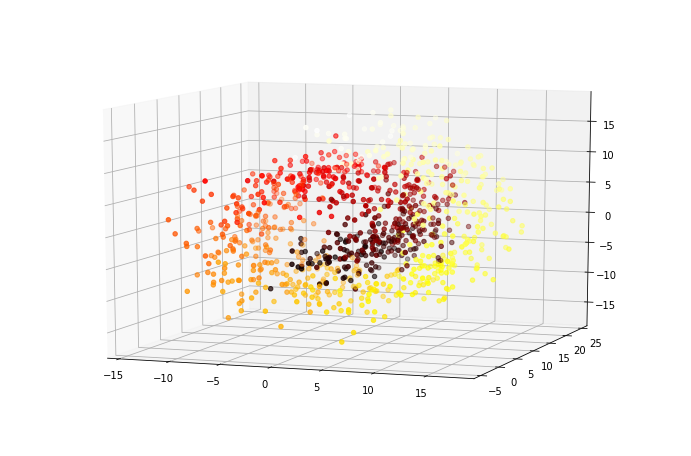

In [51]:
fig = plt.figure(figsize= (12,8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[:, 0],X[:, 1], X[:, 2], c = t , cmap = plt.cm.hot)
ax.view_init(10, -70)

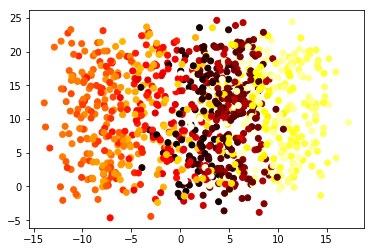

In [72]:
plt.scatter(X[:, 0], X[:, 1], c = t, cmap = plt.cm.hot)

In [79]:
a = np.arange(1,5, 1)
b = np.arange(-4,0,1)

In [81]:
a

array([1, 2, 3, 4])

In [82]:
b

array([-4, -3, -2, -1])

In [86]:
x1, x2 = np.meshgrid(a,b)

In [87]:
x1

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [88]:
x2

array([[-4, -4, -4, -4],
       [-3, -3, -3, -3],
       [-2, -2, -2, -2],
       [-1, -1, -1, -1]])

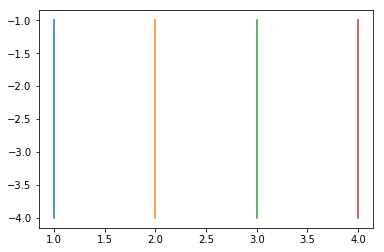

In [89]:
plt.plot(x1,x2)